# Test of class Hamiltonian_QED



This notebook uses the class in 'Hamiltonian_QED_oprt.py' and 'Hamiltonian_QED_sym.py' that builds the Hamiltonian in terms of Pauli matrices.


In [1]:
import qiskit

In [2]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
from itertools import permutations
from scipy.sparse.linalg import eigsh

In [3]:
sys.path.append("../") # go to parent dir
from qclatticeh.hamiltonian.Hamiltonian_QED_sym import HamiltonianQED_sym
from qclatticeh.hamiltonian.Hamiltonian_QED_oprt import HamiltonianQED_oprt
from qclatticeh.lattice.HC_Lattice import HCLattice

/Users/emilrosanowski/ownCloud/Zwischenspeicher/Masterarbeit/Project/CodeDelevelopment/QC_lattice_H/notebooks/../qclatticeh/hamiltonian/Hamiltonian_QED_oprt.py:748: SyntaxWarning: invalid escape sequence '\d'
  i for i in index_op if int(re.findall("\d+", i)[0]) < len(ferm_lst)


##### Class Hamilt

In [4]:
#class input parameters:
n_sites = [3,2]#how many sites for every dimension
n_flavors = 2#how many flavors of particles

#Hamiltonian parameters:
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = False
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli=True
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 2

In [5]:
latt = HCLattice(n_sites,pbc=pbc,n_flavors=n_flavors)


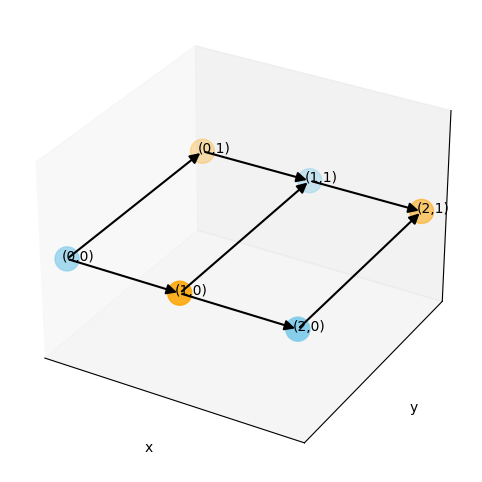

In [6]:

latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)


In [7]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [20]:
#Input parameters for the Hamiltonian
from sympy import Symbol

e_op_free_input_f=['q_00', 'q_10', 'q_20', 'q_30', 'q_40', 'q_50', 'q_01', 'q_11', 'q_21', 'q_31', 'q_41']
e_op_free_input_g=['E_20y', 'E_10y']
e_op_free_input=[Symbol(e) for e in e_op_free_input_f[::-1]+e_op_free_input_g[::-1]]

In [ ]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'n_flavors': n_flavors,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': None,
    'e_op_out_plus': e_op_out_plus,
    'e_op_free_input':e_op_free_input
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=True)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

Alpha angle α=2 π/2L+1
HamiltonianQED_sym: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: None


Eq(-E_00x - E_00y - q_00 - q_10, 0)

Eq(E_00y - E_01x - q_01 - q_11, 0)

Eq(E_00x - E_10x - E_10y - q_20 - q_30, 0)

Eq(E_01x + E_10y - E_11x - q_21 - q_31, 0)

Eq(E_10x - E_20y - q_40 - q_50, 0)

Eq(E_11x + E_20y - q_41 - q_51, 0)

Eq(q_00 + q_01 + q_10 + q_11 + q_20 + q_21 + q_30 + q_31 + q_40 + q_41 + q_50 + q_51, 0)

- E_{00x} - E_{00y} - q_{00} - q_{10} &= 0 \\ \nonumber
E_{00y} - E_{01x} - q_{01} - q_{11} &= 0 \\ \nonumber
E_{00x} - E_{10x} - E_{10y} - q_{20} - q_{30} &= 0 \\ \nonumber
E_{01x} + E_{10y} - E_{11x} - q_{21} - q_{31} &= 0 \\ \nonumber
E_{10x} - E_{20y} - q_{40} - q_{50} &= 0 \\ \nonumber
E_{11x} + E_{20y} - q_{41} - q_{51} &= 0 \\ \nonumber
q_{00} + q_{01} + q_{10} + q_{11} + q_{20} + q_{21} + q_{30} + q_{31} + q_{40} + q_{41} + q_{50} + q_{51} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + E_20y**2 + (E_20y + q_40 + q_50)**2 + (E_10y + E_20y + q_20 + q_30 + q_40 + q_50)**2 + (-E_10y - E_20y - q_00 - q_10 - q_20 - q_30 - q_40 - q_50)**2 + (-E_10y - E_20y - q_00 - q_01 - q_10 - q_11 - q_20 - q_30 - q_40 - q_50)**2 + (-E_20y - q_00 - q_01 - q_10 - q_11 - q_20 - q_21 - q_30 - q_31 - q_40 - q_50)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + E_{20y}^{2} + \left(E_{20y} + q_{40} + q_{50}\right)^{2} + \left(E_{10y} + E_{20y} + q_{20} + q_{30} + q_{40} + q_{50}\right)^{2} + \left(- E_{10y} - E_{20y} - q_{00} - q_{10} - q_{20} - q_{30} - q_{40} - q_{50}\right)^{2} + \left(- E_{10y} - E_{20y} - q_{00} - q_{01} - q_{10} - q_{11} - q_{20} - q_{30} - q_{40} - q_{50}\right)^{2} + \left(- E_{20y} - q_{00} - q_{01} - q_{10} - q_{11} - q_{20} - q_{21} - q_{30} - q_{31} - q_{40} - q_{50}\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + U_20y*Dagger(U_10y) + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + U_{20y} U_{10y}^{\dagger} + h.c.}{2 g^{2}}


Eq(H_K, Omega*(-0.5*(h.c.(y) + Dagger(Phi_1)*Phi_11 + Dagger(Phi_2)*Phi_12 - Dagger(Phi_3)*Dagger(U_10y)*Phi_9 - Dagger(Phi_4)*Dagger(U_10y)*Phi_10 + Dagger(Phi_5)*Dagger(U_20y)*Phi_7 + Dagger(Phi_6)*Dagger(U_20y)*Phi_8) + 0.5*I*(-h.c.(x) + Dagger(Phi_1)*Phi_3 + Dagger(Phi_10)*Phi_8 + Dagger(Phi_11)*Phi_9 + Dagger(Phi_12)*Phi_10 + Dagger(Phi_2)*Phi_4 + Dagger(Phi_3)*Phi_5 + Dagger(Phi_4)*Phi_6 + Dagger(Phi_9)*Phi_7)))

H_{K} = \Omega \left(- 0.5 \left(h.c.(y) + \Phi_{1}^{\dagger} \Phi_{11} + \Phi_{2}^{\dagger} \Phi_{12} - \Phi_{3}^{\dagger} U_{10y}^{\dagger} \Phi_{9} - \Phi_{4}^{\dagger} U_{10y}^{\dagger} \Phi_{10} + \Phi_{5}^{\dagger} U_{20y}^{\dagger} \Phi_{7} + \Phi_{6}^{\dagger} U_{20y}^{\dagger} \Phi_{8}\right) + 0.5 i \left(- h.c.(x) + \Phi_{1}^{\dagger} \Phi_{3} + \Phi_{10}^{\dagger} \Phi_{8} + \Phi_{11}^{\dagger} \Phi_{9} + \Phi_{12}^{\dagger} \Phi_{10} + \Phi_{2}^{\dagger} \Phi_{4} + \Phi_{3}^{\dagger} \Phi_{5} + \Phi_{4}^{\dagger} \Phi_{6} + \Phi_{9}^{\dagger} \Phi_{7}\right)\right)


Eq(H_{m,1}, m_1*(Dagger(Phi_1)*Phi_1 - Dagger(Phi_11)*Phi_11 - Dagger(Phi_3)*Phi_3 + Dagger(Phi_5)*Phi_5 - Dagger(Phi_7)*Phi_7 + Dagger(Phi_9)*Phi_9))

H_{m,1} = m_{1} \left(\Phi_{1}^{\dagger} \Phi_{1} - \Phi_{11}^{\dagger} \Phi_{11} - \Phi_{3}^{\dagger} \Phi_{3} + \Phi_{5}^{\dagger} \Phi_{5} - \Phi_{7}^{\dagger} \Phi_{7} + \Phi_{9}^{\dagger} \Phi_{9}\right)


Eq(H_{m,2}, m_2*(Dagger(Phi_10)*Phi_10 - Dagger(Phi_12)*Phi_12 + Dagger(Phi_2)*Phi_2 - Dagger(Phi_4)*Phi_4 + Dagger(Phi_6)*Phi_6 - Dagger(Phi_8)*Phi_8))

H_{m,2} = m_{2} \left(\Phi_{10}^{\dagger} \Phi_{10} - \Phi_{12}^{\dagger} \Phi_{12} + \Phi_{2}^{\dagger} \Phi_{2} - \Phi_{4}^{\dagger} \Phi_{4} + \Phi_{6}^{\dagger} \Phi_{6} - \Phi_{8}^{\dagger} \Phi_{8}\right)
>> Gauss law applied and Hamiltonian built.  Execution time: 0.06609034538269043 seconds
[E_10y, E_20y]
[q_41, q_31, q_21, q_11, q_01, q_50, q_40, q_30, q_20, q_10, q_00, E_10y, E_20y]
(q_21**2, q_31**2, 2*q_01**2, 2*q_11**2, 3*q_00**2, 3*q_10**2, 4*E_10y**2, 4*q_20**2, 4*q_30**2, 5*q_40**2, 5*q_50**2, 6*E_20y**2, 2*E_10y*q_01, 2*E_10y*q_11, 2*E_20y*q_21, 2*E_20y*q_31, 2*q_00*q_21, 2*q_00*q_31, 2*q_01*q_21, 2*q_01*q_31, 2*q_10*q_21, 2*q_10*q_31, 2*q_11*q_21, 2*q_11*q_31, 2*q_20*q_21, 2*q_20*q_31, 2*q_21*q_30, 2*q_21*q_31, 2*q_21*q_40, 2*q_21*q_50, 2*q_30*q_31, 2*q_31*q_40, 2*q_31*q_50, 4*E_10y*q_00, 4*E_10y*q_10, 4*E_20y*q_01, 4*E_20y*q_11, 4*q_00*q_01, 4*q_00*q_11, 4*q_01*q_10, 4*q_01*q_11, 4*q_01*q_20, 4*q_01*q_30, 4*q_01*q_40, 4*q_01*q_50, 4*q_10*q_11, 4*q_11*q_20, 4*q_11*q_3

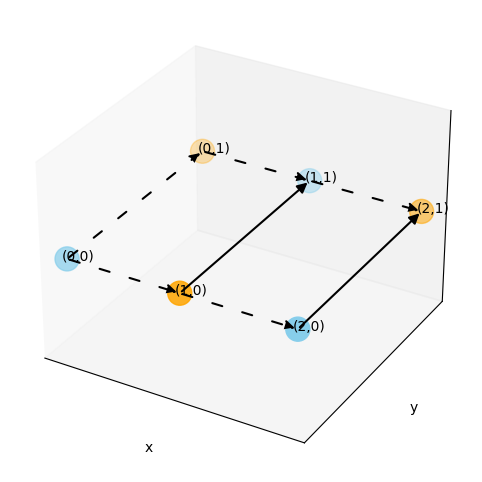

In [ ]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

##### ED spectrum

In [ ]:
import scipy.sparse as sp

In [ ]:
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot#.to_matrix(sparse=True)
    h_b_sparse = class_H_oprt.hamiltonian_mag_pauli#.to_matrix(sparse=True) #plaquette
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
spectrum, eigenvectors_matrix =eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")
#spectrum
idx = spectrum.argsort()
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of {latt.dims}D_'+'x'.join([str(i) for i in n_sites])+f'  H with mbasis{magnetic_basis} puregauge{puregauge} pbc{pbc} g{g} l{l} L{L} factE{fact_e_op} factB{fact_b_op} m{m} Omega{omega}, encoding:'+encoding)
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))

if class_H_oprt.len_e_op != 0:
    eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()
    eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    print(f'plaq={plaq}')



TypeError: HamiltonianQED_oprt.get_hamiltonian() missing 1 required positional argument: 'chem_pot'